# Lab03 - Regularization

## The code in this example has been slightly adapted from a post by Aarshay Jain on Analytics Vidhya: https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/ accessed on 2/1/17.


The goal of this worksheet is to help get familiar with the principles behind ridge and lasso regression. After completing this worksheet, you should be able to:

1) state the purpose of regularization techniques in general

2) identify the advantages of ridge and lasso over ordinary least squares

3) state scenarios in which you might prefer ridge over lasso and vice-versa

4) run these techniques on an example dataset using Python

To recieve full credit for this assignment, at a bare minimum you should answer the prompt at the end of the notebook (Step 5).

### Step 1: Set up simple Linear Regression

For our test data, let's create some points from a sine curve from 20 degrees to 320, and plot them just to be sure we have this correct.

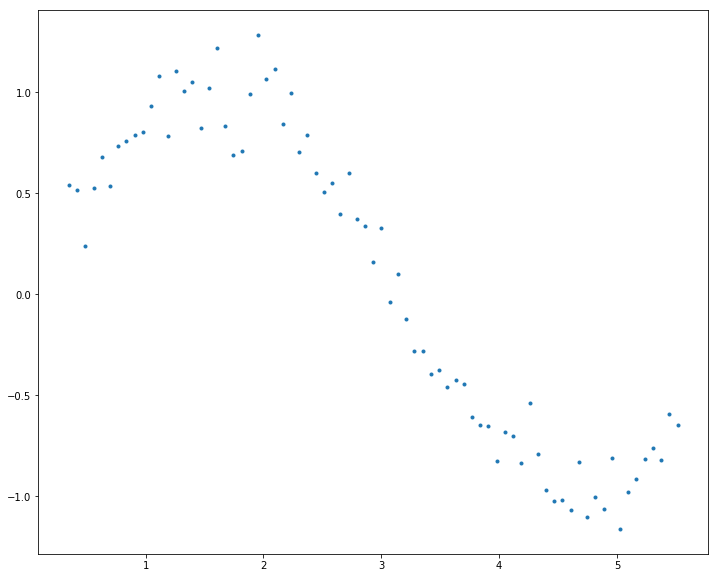

In [14]:
#
# Student Name - Charudatta Deshpande
#
# Collaborators - Ram Ganesan, Charles Hemstreet, Mehdi Muntazir, 
# Manas Thakre
#
#############################################
# Import required libraries.                # 
#############################################
#
#Importing libraries. The same will be used throughout the notebook.
#
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import os as os  
os.chdir('C:\\Users\deshc\Desktop\INFX 574 Data Science 2\Lab 3 - Regularization')
#
rcParams['figure.figsize'] = 12, 10

#Define input array with angles from 20deg to 320deg converted to radians
x = np.array([i*np.pi/180 for i in range(20,320,4)])
np.random.seed(10)  #Setting seed for reproducability
y = np.sin(x) + np.random.normal(0,0.15,len(x))
data = pd.DataFrame(np.column_stack([x,y]),columns=['x','y'])
plt.plot(data['x'],data['y'],'.')

Now that we have this set, let's try fitting some models to it. Since we want to try a multivariate fit, let's create dummy imput variables by using powers of x: x^2, x^3, etc. These will allow us to create a regression on more than one variable.

In [2]:
for i in range(2,16):  #power of 1 is already there
    colname = 'x_%d'%i      #new var will be x_power
    data[colname] = data['x']**i
print(data.head())

          x         y       x_2       x_3       x_4       x_5       x_6  \
0  0.349066  0.541758  0.121847  0.042533  0.014847  0.005182  0.001809   
1  0.418879  0.514028  0.175460  0.073496  0.030786  0.012896  0.005402   
2  0.488692  0.237662  0.238820  0.116709  0.057035  0.027873  0.013621   
3  0.558505  0.528662  0.311928  0.174214  0.097299  0.054342  0.030350   
4  0.628319  0.680986  0.394784  0.248050  0.155855  0.097926  0.061529   

        x_7       x_8       x_9      x_10      x_11      x_12      x_13  \
0  0.000631  0.000220  0.000077  0.000027  0.000009  0.000003  0.000001   
1  0.002263  0.000948  0.000397  0.000166  0.000070  0.000029  0.000012   
2  0.006657  0.003253  0.001590  0.000777  0.000380  0.000186  0.000091   
3  0.016951  0.009467  0.005287  0.002953  0.001649  0.000921  0.000514   
4  0.038660  0.024291  0.015262  0.009590  0.006025  0.003786  0.002379   

           x_14          x_15  
0  3.987522e-07  1.391908e-07  
1  5.119653e-06  2.144515e-06  
2 

We're ready to run our test! This function will do all the hard work for us by fitting the model and plotting. Note that the power we input will also be the number of variables that we fit. So, using power=1 will result in a linear model using only x, while power=2 will be a polynomial model of the form alpha + beta_1 x + beta_2 x^2.

In [3]:
#Import Linear Regression model from scikit-learn.
from sklearn.linear_model import LinearRegression

#This function will 
def linear_regression(data, power, models_to_plot):
    #initialize predictors:
    predictors=['x']
    if power>=2:
        predictors.extend(['x_%d'%i for i in range(2,power+1)])
    
    #Fit the model
    linreg = LinearRegression(normalize=True)
    linreg.fit(data[predictors],data['y'])
    y_pred = linreg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered power
    if power in models_to_plot:
        plt.subplot(models_to_plot[power])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for power: %d'%power)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([linreg.intercept_])
    ret.extend(linreg.coef_)
    return ret

Great, that's set! Time to try it out on our data, and plot a few of them for increasing number of variables.

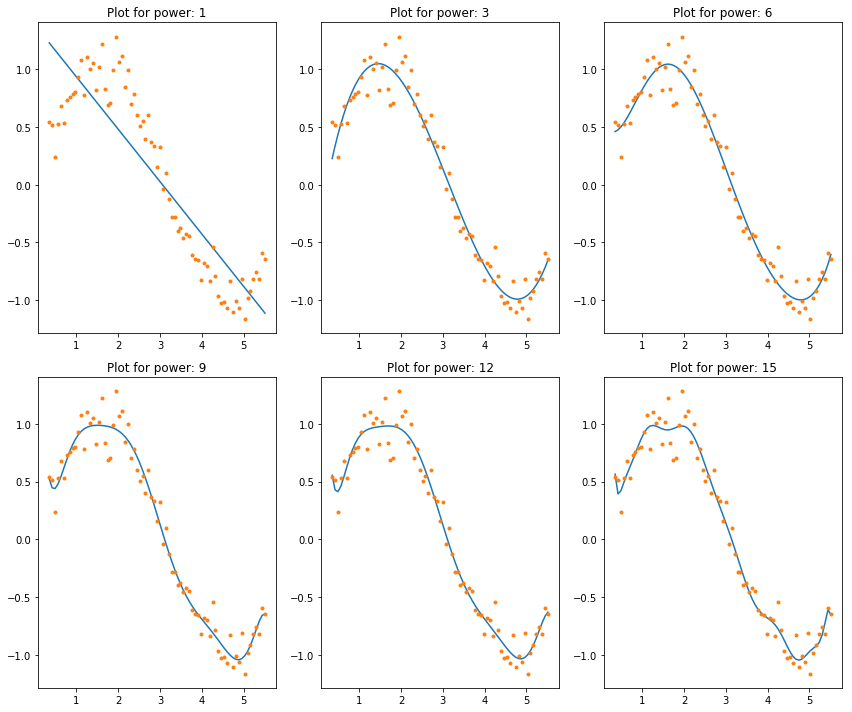

In [4]:
#Initialize a dataframe to store the results:
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['model_pow_%d'%i for i in range(1,16)]
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)

#Define the powers for which a plot is required:
models_to_plot = {1:231,3:232,6:233,9:234,12:235,15:236}

#Iterate through all powers and assimilate results
for i in range(1,16):
    coef_matrix_simple.iloc[i-1,0:i+2] = linear_regression(data, power=i, models_to_plot=models_to_plot)

Looks like overfitting to me. Lets look at our coefficients.

In [5]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_simple

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
model_pow_1,9.3,1.4,-0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_2,8.1,1,-0.091,-0.062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_3,1.4,-0.46,2.3,-1,0.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_4,1.3,-0.23,1.8,-0.65,0.013,0.0083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_5,1.2,0.19,0.41,0.7,-0.56,0.12,-0.0073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_6,1.2,0.65,-1.4,3.1,-2,0.56,-0.073,0.0037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_7,1.2,0.18,0.84,-0.66,1,-0.76,0.24,-0.034,0.0018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_8,1.2,0.42,-0.49,2.1,-1.7,0.82,-0.28,0.066,-0.0085,0.00044,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_9,1.1,3.7,-21,52,-63,45,-19,5.2,-0.84,0.075,-0.0028,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_10,1.1,5,-30,76,-98,75,-36,11,-2.1,0.26,-0.017,0.00049,NaN,NaN,NaN,NaN,NaN


Our coefficients all seem to increase as we add more variables, when there is no "real" reason for them to do so. How might we combat this effect?

### Section 2: Ridge Regression

Now we can define a function similar to the naive OLS fit we did above but using sklearn.linear_model.Ridge

In [6]:
from sklearn.linear_model import Ridge
def ridge_regression(data, predictors, alpha, models_to_plot={}):
    #Fit the model
    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(data[predictors],data['y'])
    y_pred = ridgereg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    return ret

Now we can run a similar test to what we did in step 1, but keeping all 15 variables (powers) and instead varying our lambda value

C:\Users\deshc\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.6339926949393555e-18
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\deshc\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.627405020513479e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


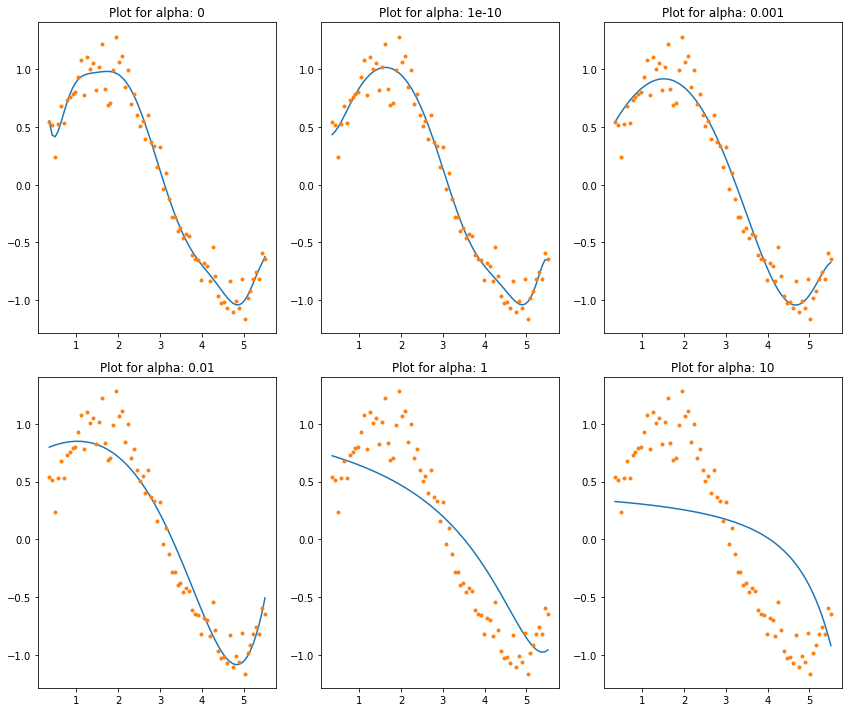

In [7]:
#Initialize predictors to be set of 15 powers of x
predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,16)])

#Set the different values of alpha to be tested
alpha_ridge = [0, 1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

#Initialize the dataframe for storing coefficients.
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_ridge[i] for i in range(0,10)]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)

models_to_plot = {0:231, 1e-10:232, 1e-3:233, 1e-2:234, 1:235, 10:236}
for i in range(10):
    coef_matrix_ridge.iloc[i,] = ridge_regression(data, predictors, alpha_ridge[i], models_to_plot)

Let's investigate how the coefficients change with varying values of alpha

In [8]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_ridge

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
alpha_0,1.1,5.6,-34,87,-1.1e+02,80,-32,5.6,0.42,-0.3,-0.0011,0.012,0.0012,-0.0014,0.00029,-2.7e-05,9.7e-07
alpha_1e-15,1.1,5.4,-33,84,-1.1e+02,81,-36,8.5,-0.55,-0.21,0.039,0.0042,-0.0015,-7.5e-05,5.9e-05,-7.2e-06,2.9e-07
alpha_1e-10,1.1,0.63,-1.8,4.9,-4.4,1.9,-0.36,-0.014,0.0097,0.00089,-0.00019,-4.7e-05,-5.1e-07,1.3e-06,1.5e-07,-3.1e-08,2.9e-10
alpha_1e-08,1.1,0.14,0.82,-0.14,0.055,-0.035,-0.011,0.002,0.00078,5.8e-05,-1.7e-05,-6e-06,-7.3e-07,5.5e-08,4.2e-08,6.6e-09,-1.4e-09
alpha_0.0001,1.3,0.0057,1.2,-0.3,-0.04,-0.00014,0.00085,0.00019,2.7e-05,1.9e-06,-1.9e-07,-1.1e-07,-2.4e-08,-3.9e-09,-3.6e-10,3.9e-11,3.2e-11
alpha_0.001,1.6,0.31,0.74,-0.18,-0.027,-0.0015,0.0002,7.9e-05,1.5e-05,2.3e-06,2.5e-07,1.6e-08,-1.6e-09,-8.5e-10,-2e-10,-3.2e-11,-3.2e-12
alpha_0.01,3,0.74,0.2,-0.072,-0.013,-0.0015,-8.1e-05,1.2e-05,5.1e-06,1.2e-06,2.2e-07,3.4e-08,4.6e-09,4.4e-10,-2e-12,-1.6e-11,-6e-12
alpha_1,9.6,0.76,-0.1,-0.016,-0.0025,-0.00038,-5.3e-05,-6.9e-06,-8.2e-07,-7.7e-08,-2.6e-09,1.4e-09,5.4e-10,1.5e-10,3.4e-11,7.4e-12,1.5e-12
alpha_5,20,0.45,-0.044,-0.007,-0.0012,-0.00018,-2.9e-05,-4.5e-06,-7e-07,-1.1e-07,-1.6e-08,-2.3e-09,-3.2e-10,-4.3e-11,-5.2e-12,-5.3e-13,-2.6e-14
alpha_10,24,0.34,-0.028,-0.0045,-0.00076,-0.00013,-2.1e-05,-3.4e-06,-5.6e-07,-9.1e-08,-1.5e-08,-2.4e-09,-3.9e-10,-6.3e-11,-1e-11,-1.6e-12,-2.6e-13


Check to see if any of the coefficients are 0

In [9]:
coef_matrix_ridge.apply(lambda x: sum(x.values==0),axis=1)

alpha_0         0
alpha_1e-15     0
alpha_1e-10     0
alpha_1e-08     0
alpha_0.0001    0
alpha_0.001     0
alpha_0.01      0
alpha_1         0
alpha_5         0
alpha_10        0
dtype: int64

### Section 3: Lasso (Least Absolute Shrinkage and Selection Operator)

Same as before, we start defining a generic function to help us out

In [10]:
from sklearn.linear_model import Lasso
def lasso_regression(data, predictors, alpha, models_to_plot={}):
    #Fit the model
    lassoreg = Lasso(alpha=alpha,normalize=True, max_iter=1e5)
    lassoreg.fit(data[predictors],data['y'])
    y_pred = lassoreg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([lassoreg.intercept_])
    ret.extend(lassoreg.coef_)
    return ret

Now we can plot different values of alpha

C:\Users\deshc\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


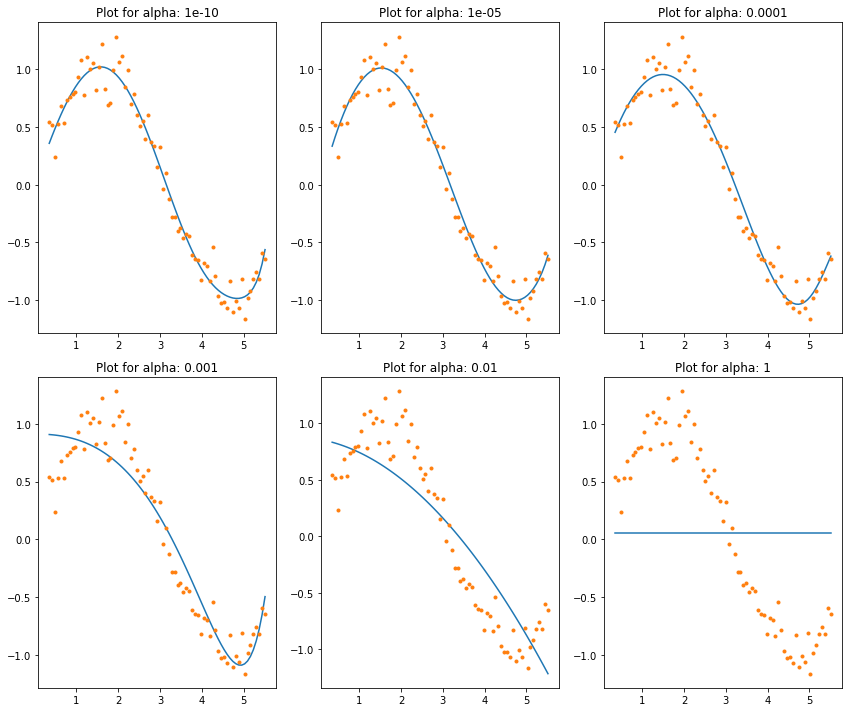

In [11]:
#Initialize predictors to all 15 powers of x
predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,16)])

#Define the alpha values to test
alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]

#Initialize the dataframe to store coefficients
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_lasso[i] for i in range(0,10)]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)

#Define the models to plot
models_to_plot = {1e-10:231, 1e-5:232,1e-4:233, 1e-3:234, 1e-2:235, 1:236}

#Iterate over the 10 alpha values:
for i in range(10):
    coef_matrix_lasso.iloc[i,] = lasso_regression(data, predictors, alpha_lasso[i], models_to_plot)

Looks like we serverly underfit when alpha = 1. Are any of the coefficients 0?

In [12]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_lasso

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
alpha_1e-15,1.2,0.0062,1.1,-0.07,-0.14,0.0058,0.0027,0.00032,8.4e-06,-4.5e-06,-1.2e-06,-1.8e-07,-1.7e-08,-1.3e-10,3.6e-10,9.3e-11,1.3e-11
alpha_1e-10,1.2,0.0062,1.1,-0.07,-0.14,0.0058,0.0027,0.00032,8.4e-06,-4.5e-06,-1.2e-06,-1.8e-07,-1.7e-08,-1.3e-10,3.6e-10,9.3e-11,1.3e-11
alpha_1e-08,1.2,0.0062,1.1,-0.07,-0.14,0.0058,0.0028,0.00032,8.3e-06,-4.4e-06,-1.2e-06,-1.8e-07,-1.7e-08,-1.2e-10,3.5e-10,9.4e-11,1.3e-11
alpha_1e-05,1.3,-0.13,1.5,-0.49,-0.0074,0,0.0012,0.00014,0,-0,-0,-6.3e-08,-2e-08,-0,-0,0,1.3e-11
alpha_0.0001,1.4,0.1,1.2,-0.39,-0,0,0,0.00019,0,0,0,0,-0,-0,-0,-0,-5.5e-12
alpha_0.001,3.9,0.91,0,-0.031,-0.016,-0,-0,0,0,0,0,6.2e-08,4.7e-09,0,0,0,0
alpha_0.01,8.7,0.86,-0.063,-0.057,-0,-0,-0,0,0,0,0,0,0,0,0,0,0
alpha_1,45,0.059,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
alpha_5,45,0.059,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
alpha_10,45,0.059,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0


In [13]:
coef_matrix_lasso.apply(lambda x: sum(x.values==0),axis=1)

alpha_1e-15      0
alpha_1e-10      0
alpha_1e-08      0
alpha_1e-05      7
alpha_0.0001    11
alpha_0.001     11
alpha_0.01      13
alpha_1         15
alpha_5         15
alpha_10        15
dtype: int64

### Step 4: Try it yourself!

Below you will find some code to load the auto data used in the splitting data lab. Use this data to try out OLS, Ridge, and Lasso for predicting MPG in germs of the other variables in the dataset. Compare the coefficients from each method to see what the difference is. Try varying your alpha value as well!

In [15]:
auto_data = pd.read_csv("Auto.csv")
auto_data = auto_data[auto_data.horsepower != '?'] #get rid of pesky "?" values

response = "mpg" #identifies which variable we want to try to predict
#predict based on all values other than name, since it is non-numeric
#feel free to change this to any subset that you want to use to predict!
predictors = ['cylinders','displacement','horsepower','weight','acceleration','year','origin']

auto_data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18,8,3.1e+02,130,3504,12,70,1,chevrolet chevelle malibu
1,15,8,3.5e+02,165,3693,12,70,1,buick skylark 320
2,18,8,3.2e+02,150,3436,11,70,1,plymouth satellite
3,16,8,3e+02,150,3433,12,70,1,amc rebel sst
4,17,8,3e+02,140,3449,10,70,1,ford torino


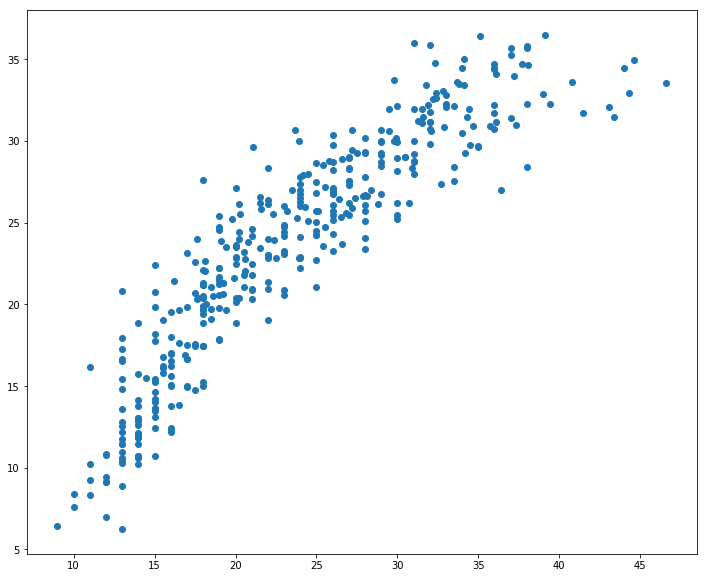

In [21]:
#Run a OLS linear regression
#
# Charu's comment - we will use LinearRegression function for this 
#
from sklearn.linear_model import LinearRegression

#Fit the model
linear_regression = LinearRegression(normalize=True)
linear_regression.fit(auto_data[predictors],auto_data['mpg'])
linear_predicted = linear_regression.predict(auto_data[predictors])

plt.scatter(auto_data['mpg'],lm_pred)


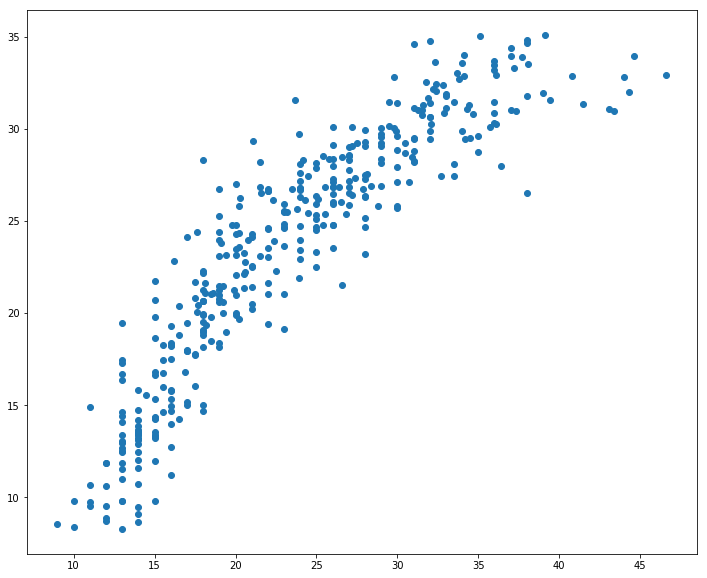

In [22]:
#Run a Ridge regression
#
# Charu's comment - we will use Ridge function for this 
#
ridge_regression = Ridge(alpha=0.1,normalize=True)
ridge_regression.fit(auto_data[predictors],auto_data['mpg'])
ridge_predicted = ridge_regression.predict(auto_data[predictors])

plt.scatter(auto_data['mpg'],ridge_predicted)


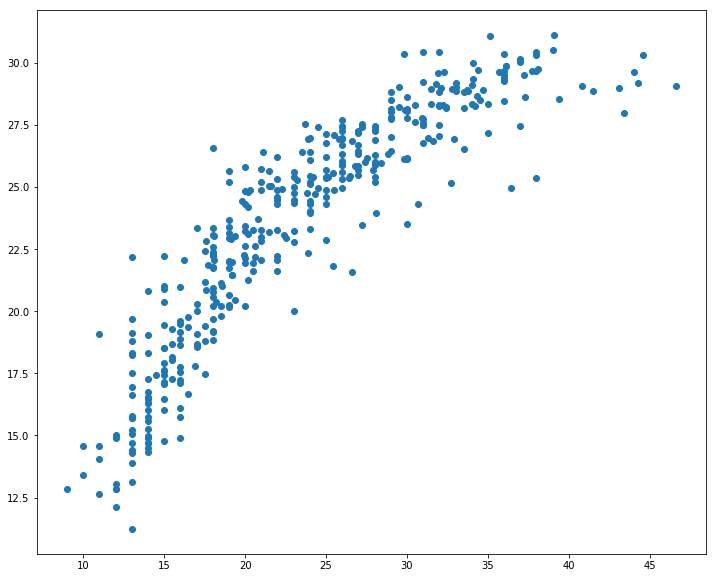

In [23]:
#Run a Lasso regression
#
# Charu's comment - we will use Lasso function for this 
#
from sklearn.linear_model import Lasso
lasso_regression = Lasso(alpha=0.1,normalize=True, max_iter=1e5)
lasso_regression.fit(auto_data[predictors],auto_data['mpg'])
lasso_predicted = lasso_regression.predict(auto_data[predictors])
plt.scatter(auto_data['mpg'],lasso_predicted)


In [30]:
#Show linear coefficients
print("Linear Regression Intercept: ", [linear_regression.intercept_])
print("Linear Regression Coefficients: ", linear_regression.coef_)
print("Linear Regression Predicted - Score: ", linear_regression.score
      (auto_data[predictors], linear_predicted))


Linear Regression Intercept:  [-17.218434622017565]
Linear Regression Coefficients:  [-0.49337632  0.01989564 -0.01695114 -0.00647404  0.08057584  0.75077268
  1.4261405 ]
Linear Regression Predicted - Score:  1.0


In [31]:
#Show ridge coefficients
print("Ridge Regression Intercept: ", [ridge_regression.intercept_])
print("Ridge Regression Coefficient: ", ridge_regression.coef_)
print("Ridge Regression Predicted - Score: ", ridge_regression.score
      (auto_data[predictors], ridge_predicted))


Ridge Regression Intercept:  [-10.578373279290272]
Ridge Regression Coefficient:  [-0.41009338 -0.00347679 -0.0283652  -0.0035382  -0.05425655  0.64846559
  1.27867681]
Ridge Regression Predicted - Score:  1.0


In [32]:
#Show lasso coefficients
print("Lasso Regression Intercept: ", [lasso_regression.intercept_])
print("Lasso Regression Coefficient: ", lasso_regression.coef_)
print("Lasso Regression Predicted - Score: ", lasso_regression.score
      (auto_data[predictors], lasso_predicted))

Lasso Regression Intercept:  [11.598419932477311]
Lasso Regression Coefficient:  [ -0.00000000e+00  -0.00000000e+00  -1.59227970e-04  -4.84342104e-03
   0.00000000e+00   3.45959041e-01   0.00000000e+00]
Lasso Regression Predicted - Score:  1.0


#### Which predictors did Lasso select (non-zero coefficients)? Does this match your intuition for which predictors are the most significant?

Predictor Variables -      
         
cylinders             
displacement           
horsepower          
weight          
acceleration         
year       
origin       
     
All of them seem to be relevant, except probably the origin. But even origin may play some 
part in the algorithm. Different origins may represent different outcomes. E.g. Japanese cars       
(origin = Asia) may be more technologically advanced than some European cars which may lead to
a better mpg etc.                  
          
          

### Step 5: Reflection

#### Overall, which of the three methods did you find to be the best fit for the data you investigated (OLS, Ridge, Lasso)? Explain your answer, and be sure to discuss what specific strengths this approach has.

I believe Lasso method worked best in this particularly scenario.       
       
OLS is inherently weak here since it is linear model and mpg hardly has linear relationship      
with any of the predictors. From my previous labs for Linear Regresion,    
I believe the most significant predictor happens to be the 'year', probably           
more than it should. When I last did some experiements with the year,           
it seemed to predict much higher mpg for cars 2010 and newer. This may not      
happen in real world. This is due to inherent nature of the linear model.         
       
Ridge, while better than Linear, does not do auto selection of predictors and includes       
non-relevant parameters.       
       
Lasso does auto predictor selection and includes the most relevent predictors in the model.       
      